<a href="https://colab.research.google.com/github/abubakrsiddq/ImageDehazing/blob/main/models/DeHazenet/dehazenet_kitti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_addons

     |████████████████████████████████| 686kB 7.2MB/s 


In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime
import keras
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

from tensorflow.keras.applications import *
from tensorflow.keras.losses import MAE, MSE

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    
    img = tf.io.decode_png(img, channels = 3)
    img = tf.image.resize(img, size = (352 , 1216), antialias = True)
    img = img / 255.0
    return img

In [11]:
def dataset_preposses(orig_img_path='/content/drive/MyDrive/generated_dataset/trans',hazy_img_path='/content/drive/MyDrive/generated_dataset/hazy',percentage=0.1,validation_size=200,test_size=64,seed_val=200):
    train_img = []
    val_img = []
    random.seed=seed_val
    orig_img = glob.glob(orig_img_path + '/*.png')
    n = len(orig_img)
    random.shuffle(orig_img)
    red_keys=orig_img[:]                                 #redundant keys to avoid key error
    train_keys = orig_img[:int(0.9*n*percentage)]
    #print(0.9*n*percentage)
    #print(len(train_keys))
    val_keys = orig_img[-int(0.1*n*percentage):]
    #print(len(val_keys))
    split_dict = {}
    #i=0
    for key in red_keys:
      split_dict[key]='red'
      #i+=1
    #print(i)
    for key in train_keys:
      split_dict[key] = 'train'
    for key in val_keys:
      split_dict[key] = 'val'
      
    hazy_img = glob.glob(hazy_img_path + '/*.png')
    for img in hazy_img:
      
      img_name = img.split('/')[-1][:-4].split('_')[0]
      orig_path = orig_img_path + '/' + img_name+'.png'
      if (split_dict[orig_path] == 'train'):
        train_img.append([img, orig_path])
      if (split_dict[orig_path] == 'val'):
        val_img.append([img, orig_path])
      

    return train_img, val_img


def gen_dataset(ar):
  '''
  parameters
  list of paths
  return
  list with gt attached 
  '''
  orig_path='/content/drive/MyDrive/kitti/gt'
  haze_pth='/content/drive/MyDrive/kitti/hazy'
  lst=[]
  for i in ar:
    name=i.split('/')[-1].split('_')[0]
    pthlist=[i,orig_path+'/'+name+'.jpg']
    lst.append(pthlist)
  return lst

def data_path(orig_img_path = '/content/drive/MyDrive/kitti/gt', hazy_img_path = '/content/drive/MyDrive/kitti/hazy'):
  
  (a,b,c)=dataset_preposses(orig_path=orig_img_path,haze_path=hazy_img_path)
  a=gen_dataset(a)
  b=gen_dataset(b)
  return a,b

In [12]:
def dataloader(train_data, val_data, batch_size):
    print(len(train_data))
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    return train, val

In [13]:
def display_img(model, hazy_img, orig_img):
    
    dehazed_img = model(hazy_img,training = False)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], dehazed_img[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(3, 1, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        directory='/content/drive/MyDrive/Test/padCheck'
        os.chdir(directory)
        filename=str(i)+'.jpg'
        tf.keras.preprocessing.image.save_img(filename,display_list[i],)
        #plt.imsave('plt'+filename,display_list[i])
    plt.show()

In [ ]:
r = 50;
eps = 10^-3; 


def boxfilter(bwim , r = 50):
  
  h , w , _ = tf.shape(bwim)
  imDst  = tf.zeros([h, w], tf.int32)
  
  
  #cumulative sum over Y axis
  imCum = tf.cumsum(in_num)

  #difference over Y axis
  imDst[1:(r+1), :] = imCum[1+r:2*r+1, :]
  imDst[r+2:h-r, :] = imCum[2*r+2:h, :] - imCum[1:h-2*r-1, :]
  d = tf.constant([50, 1], tf.int32)
  imDst[h-r+1:h, :] = tf.tile(imCum[h, :], d) - imCum[h-2*r:h-r-1, :]

  #cumulative sum over X axis
  imCum = tf.cumsum(imDst, 2);

  #difference over X axis
  imDst[:, 1:r+1] = imCum[:, 1+r:2*r+1]
  imDst[:, r+2:w-r] = imCum[:, 2*r+2:w] - imCum[:, 1:w-2*r-1]
  c = tf.constant([1,50], tf.int32)
  imDst[:, w-r+1:w] = tf.tile[imCum[:, w], c] - imCum[:, w-2*r:w-r-1]

  return imDst



def guidedfilter(bwim, out, r , eps):

  h , w , _ = tf.shape(bwim)
  N = boxfilter(ones(h, w), r);

  mean_I = boxfilter(bwim, r) / N;
  mean_p = boxfilter(out, r) / N;
  mean_Ip = boxfilter(bwim*out, r) / N;
  cov_Ip = mean_Ip - mean_I * mean_p;


  mean_II = boxfilter(bwim*bwim, r)/ N;
  var_I = mean_II - mean_I * mean_I;

  a = cov_Ip / (var_I + eps); 
  b = mean_p - a * mean_I;

  mean_a = boxfilter(a, r) / N;
  mean_b = boxfilter(b, r) / N;

  q = mean_a * I + mean_b;

  return q

def indices(a, func):
    return [i for (i, val) in enumerate(a) if func(val)]



def atmlight(out, bwim, im):

  sortdata = tf.sort(out, axis=0)
  b = tf.shape(sortdata)
  b = max(b)
  idx = round(0.01 * b)
  val = sortdata(idx)
  id_set = indices(out, lambda x: x <= val)
  BrightPxls = bwim(id_set)
  iBright = (BrightPxls >= BrightPxls.max())
  id = id_set(iBright)
  Itemp = tf.reshape(im,(len(im[0])*len(im[1]),len(im[2])))
  A = tf.mean(Itemp[id, :],1)
  A= tf.reshape(A,(1,1,3))



  F4 = guidedfilter(bwim, out, r, eps)

  J= im - A
  J= J / F4
  J= J + A
  dehaze = J

  return dehaze


In [ ]:
class Maxout(tf.keras.layers.Layer):
    """Applies Maxout to the input.

    "Maxout Networks" Ian J. Goodfellow, David Warde-Farley, Mehdi Mirza, Aaron
    Courville, Yoshua Bengio. https://arxiv.org/abs/1302.4389

    Usually the operation is performed in the filter/channel dimension. This
    can also be used after Dense layers to reduce number of features.

    Args:
      num_units: Specifies how many features will remain after maxout
        in the `axis` dimension (usually channel).
        This must be a factor of number of features.
      axis: The dimension where max pooling will be performed. Default is the
        last dimension.

    Input shape:
      nD tensor with shape: `(batch_size, ..., axis_dim, ...)`.

    Output shape:
      nD tensor with shape: `(batch_size, ..., num_units, ...)`.
    """


    def __init__(self, num_units: int, axis: int = -1, **kwargs):
        super().__init__(**kwargs)
        self.num_units = num_units
        self.axis = axis


    def call(self, inputs):
        inputs = tf.convert_to_tensor(inputs)
        shape = inputs.get_shape().as_list()
        # Dealing with batches with arbitrary sizes
        for i in range(len(shape)):
            if shape[i] is None:
                shape[i] = tf.shape(inputs)[i]


        num_channels = shape[self.axis]
        if not isinstance(num_channels, tf.Tensor) and num_channels % self.num_units:
            raise ValueError(
                "number of features({}) is not "
                "a multiple of num_units({})".format(num_channels, self.num_units)
            )


        if self.axis < 0:
            axis = self.axis + len(shape)
        else:
            axis = self.axis
        assert axis >= 0, "Find invalid axis: {}".format(self.axis)


        expand_shape = shape[:]
        expand_shape[axis] = self.num_units
        k = num_channels // self.num_units
        expand_shape.insert(axis, k)


        outputs = tf.math.reduce_max(
            tf.reshape(inputs, expand_shape), axis, keepdims=False
        )
        return outputs


    def compute_output_shape(self, input_shape):
        input_shape = tf.TensorShape(input_shape).as_list()
        input_shape[self.axis] = self.num_units
        return tf.TensorShape(input_shape)


    def get_config(self):
        config = {"num_units": self.num_units, "axis": self.axis}
        base_config = super().get_config()
        return {**base_config, **config}

In [ ]:
def AtmLight(im,dark):
	numpx = 428
	darkvec = dark.reshape(imsz,1)
	imvec = im.reshape(imsz,3)
	indices = darkvec.argsort()
	indices = indices[imsz-numpx::]
	atmsum = np.zeros([1,3])
	for ind in range(1,numpx):
		atmsum = atmsum + imvec[indices[ind]]
	A = atmsum / numpx
	return A

def DarkChannel(im,w):
    M = 352
    N = 1216
    padded = tf.pad(im, ((w / 2, w / 2), (w / 2, w / 2), (0, 0)))
    darkch = tf.zeros((M, N))
    for i, j in np.ndindex(darkch.shape):
        darkch[i, j] = tf.math.minimum(padded[i:i + w, j:j + w, :])  # CVPR09, eq.5
    return darkch

In [ ]:
A=tf.keras.models.load_model('/content/drive/MyDrive/nets/prelim_model/simple_a_net')

In [ ]:
#def dehaze_net():
class dehaze_net(tf.keras.Model):
  def __init__(self):
    super(dehaze_net,self).__init__()
    self.conv1 = Conv2D(input_shape = (352, 1216, 3), filters = 16, kernel_size = 5, strides = 1, padding = 'same', use_bias = True)
    self.Maxout=Maxout(num_units=4,axis= -1)
    self.conv2 = Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'same', use_bias = True)
    self.conv3 = Conv2D(filters = 16, kernel_size = 5, strides = 1, padding = 'same', use_bias = True)
    self.conv4 = Conv2D(filters = 16, kernel_size = 7, strides = 1, padding = 'same', use_bias = True)
    self.maxpool=MaxPool2D(7,strides=1,padding='same')
    self.conv5 = Conv2D(filters = 1, kernel_size = 6, strides = 1, padding = 'same', use_bias = True)
    #self.a_net=A
    


  def call(self,inputs):
    A1 = self.a_net(inputs)
    exp = tf.expand_dims(A1, axis=1)
    A = tf.expand_dims(exp, axis=2)
    
    out = self.conv1(inputs)
    out = self.Maxout(out)
    out1 = self.conv2(out)
    out2 = self.conv3(out)
    out3 = self.conv4(out)
    y=tf.keras.layers.concatenate([out1,out2,out3])
    y = self.maxpool(y)
    y1 = self.conv5(y)
    sub = tf.math.subtract(1.0,y1)
    sub1 = tf.dtypes.cast(sub, tf.int32)
    y2= ReLU(max_value = 1.0)(sub1)#(tf.math.add(tf.math.multiply(y,inputs),tf.math.multiply(sub1,A)))
    return y2


  def model(self):
        x = Input(shape = (352, 1216, 3))
        return Model(inputs=[x], outputs=self.call(x))

    
  def build_graph(self):
        x = Input(shape= (352, 1216, 3))
        return Model(inputs=[x], outputs=self.call(x))



In [ ]:
def dehaze_net():
    
    inputs = tf.keras.Input(shape = [352, 1216, 3])
    conv1 = Conv2D(input_shape = (352, 1216, 3), filters = 3, kernel_size = 1, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(inputs)
    conv2 = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(conv1)
    concat1 = tf.concat([conv1,conv2], axis = -1)
    
    conv3 = Conv2D(filters = 3, kernel_size = 5, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(concat1)
    concat2 = tf.concat([conv2,conv3], axis = -1)
    
    conv4 = Conv2D(filters = 3, kernel_size = 7, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(concat2)
    concat3 = tf.concat([conv1,conv2,conv3,conv4], axis = -1)
    
    conv5 = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(concat3)
    K = conv5
    output = ReLU(max_value = 1.0)(tf.math.multiply(K,inputs) - K + 1.0)
    
    #model = Model(inputs = x, outputs = output)
    
    return Model(inputs = inputs, outputs = output)

In [ ]:
model=dehaze_net()
model.summary()
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model.build_graph(), to_file=dot_img_file, show_shapes=True)

NameError: ignored

In [ ]:
A=tf.keras.models.load_model('/content/drive/MyDrive/nets/prelim_model/simple_a_net')

In [ ]:
class dehaze_net(tf.keras.Model):
  def __init__(self):
    super(dehaze_net,self).__init__()

  

  def call(self,inputs):   
    #inputs = tf.keras.Input(shape = [413,550,3])
    #pad=tf.keras.layers.ZeroPadding2D(padding=(1, 1))(inputs)
    #atm=self.get_dark_channel(inputs,15)
    #atm=self.atmlight(inputs,atm)
    conv1 = Conv2D(input_shape = (352, 1216, 3), filters = 3, kernel_size = 1, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(inputs)
    
    conv2 = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(conv1)
    concat1 = tf.concat([conv1,conv2], axis = -1)
    
    conv3 = Conv2D(filters = 3, kernel_size = 5, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(concat1)
    concat2 = tf.concat([conv2,conv3], axis = -1)
    
    conv4 = Conv2D(filters = 3, kernel_size = 7, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(concat2)
    concat3 = tf.concat([conv1,conv2,conv3,conv4], axis = -1)
    
    conv5 = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(concat3)
    K = conv5
    output = ReLU(max_value = 1.0)(tf.math.multiply(K,inputs) - K + 1.0)
    #output1=tf.image.resize_with_crop_or_pad(output1, 412, 548)
    #output=tf.image.resize(output1, size = (413, 550), antialias = True)
    #model = Model(inputs = x, outputs = output)
    
    return output

  def model(self):
        x = Input(shape = (352, 1216, 3))
        return Model(inputs=[x], outputs=self.call(x))

    
  def build_graph(self):
        x = Input(shape=(352, 1216, 3))
        return Model(inputs=[x], outputs=self.call(x))

In [ ]:
#def dehaze_net():
class dehaze_net_V2(tf.keras.Model):
  def __init__(self):
    super(dehaze_net_V2,self).__init__()
    self.conv1 = Conv2D(filters = 16, kernel_size = 5, strides = 1, padding = 'same', use_bias = True)
    #self.a_net=A
    self.Maxout=tfa.layers.Maxout(num_units=4,axis= -1)
    self.conv2 = Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'same', use_bias = True)
    self.conv3 = Conv2D(filters = 16, kernel_size = 5, strides = 1, padding = 'same', use_bias = True)
    self.conv4 = Conv2D(filters = 16, kernel_size = 7, strides = 1, padding = 'same', use_bias = True)
    self.maxpool=MaxPool2D(7,strides=1,padding='same')
    self.conv5 = Conv2D(filters = 3, kernel_size = 6, strides = 1, padding = 'same', use_bias = True)
    


  def call(self,inputs):
    #A1 = self.a_net(inputs)
    #exp = tf.expand_dims(A1, axis=1)
    #A = tf.expand_dims(exp, axis=2)
    out = self.conv1(inputs)
    out = self.Maxout(out)
    out1 = self.conv2(out)
    out2 = self.conv3(out)
    out3 = self.conv4(out)
    y=tf.keras.layers.concatenate([out1,out2,out3])
    y = self.maxpool(y)
    y = self.conv5(y)
    #print(y.shape)
    y= ReLU(max_value = 1.0)(y)
    #out=tf.add(tf.math.divide_no_nan(tf.add(inputs,-(A)),y),A) 
    return y

   #K = conv5
   #output = ReLU(max_value = 1.0)(tf.math.multiply(K,inputs) - K + 1.0)
   #output1=tf.image.resize_with_crop_or_pad(output1, 412, 548)
   #output=tf.image.resize(output1, size = (413, 550), antialias = True)
   #model = Model(inputs = x, outputs = output)
   
   #return output

  def model(self):
        x = Input(shape = (352, 1216, 3))
        return Model(inputs=[x], outputs=self.call(x))

    
  def build_graph(self):
        x = Input(shape=(352, 1216, 3))
        return Model(inputs=[x], outputs=self.call(x))



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 352, 1216, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 352, 1216, 16 1216        input_1[0][0]                    
__________________________________________________________________________________________________
maxout (Maxout)                 (None, 352, 1216, 4) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 352, 1216, 16 592         maxout[0][0]                     
______________________________________________________________________________________________

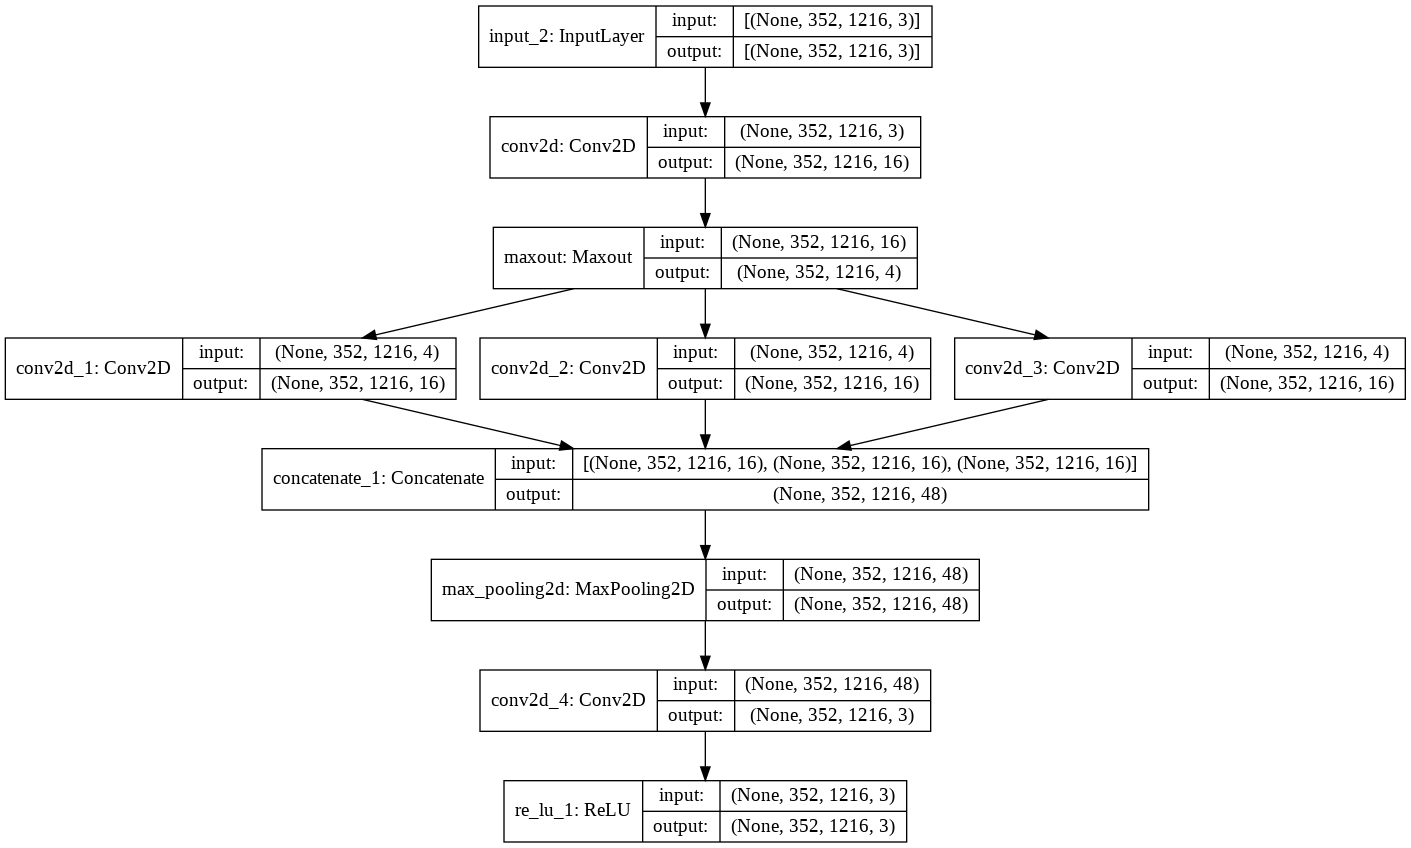

In [ ]:
model=dehaze_net_V2()

model.model().summary()
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model.build_graph(), to_file=dot_img_file, show_shapes=True)

In [31]:
model=tf.keras.models.load_model('/content/drive/MyDrive/kitti_nets/dehazenet/')

In [23]:
# Hyperparameters
epochs = 10

k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()
batch_size=8
train_data, val_data = dataset_preposses(orig_img_path = '/content/drive/MyDrive/kitti/gt', hazy_img_path = '/content/drive/MyDrive/kitti/hazy',percentage=0.4,seed_val=12)
train, val = dataloader(train_data, val_data, batch_size)
#net = Unsuper_net()
#optimizer = Adam(learning_rate = 1e-7)
train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")

2160


In [28]:

def lossVGG(y_true, y_pred):
	vgg = VGG19(include_top=False, weights='imagenet')
	vgg.trainable = False
	content_layers = 'block2_conv2'

	lossModel = Model(vgg.input, vgg.get_layer(content_layers).output)

	vggX = lossModel(y_pred)
	vggY = lossModel(y_true)
	
	return K.mean(K.square(vggX - vggY)) 

def my_loss(y_true, y_pred):
	mse = MAE(y_true, y_pred)
	return 0.1*lossVGG(y_true, y_pred) + mse

In [29]:
def train_model(epochs, train, val,net,train_loss_tracker,val_loss_tracker, optimizer):
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()
        
        # training loop
        
        for step, (train_batch_haze, train_batch_orig) in enumerate(train):

            with tf.GradientTape() as tape:

                #train_logits = net(train_batch_haze,train_batch_orig,training = True)
                #t=t_net(train_batch_haze)
                #a=a_net(train_batch_haze)
                #out=tf.add(tf.multiply(train_batch_orig,t),tf.multiply(a,(1-t)))
                train_logits=net(train_batch_haze,training=True)
                #loss = mean_squared_error(train_batch_haze,train_logits)
                loss = my_loss(train_batch_orig,train_logits)
                #loss=tf.math.reduce_mean(loss,axis=None)
                #er=tf.keras.losses.MeanAbsoluteError(tf.keras.losses.Reduction.AUTO)
                #loss=er(train_batch_orig, train_logits)/batch_size
                #loss=tf.image.psnr(train_batch_orig, train_logits, max_val=1)
                #loss=tf.image.ssim(train_batch_orig, train_logits, max_val=1, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
                #loss=custom_loss(train_batch_haze,out)
                #loss=tf.math.reduce_mean(loss)
                #print(loss)

            grads = tape.gradient(loss,net.trainable_weights)
            #grads2 = tape.gradient(loss,a_net.trainable_weights)
            #optimizer.apply_gradients(zip(grads, t_net.trainable_weights))
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

            train_loss_tracker.update_state(train_batch_orig, train_logits)
            if step == 0:
                print('[', end='')
            if step % 256 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
        # validation loop
        
        for step, (val_batch_haze, val_batch_orig) in enumerate(val):
            val_logits = net(val_batch_haze)
            val_loss_tracker.update_state(val_batch_orig, val_logits)
            
            if step % 256 ==0:
                display_img(net, val_batch_haze, val_batch_orig)
        
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        #net.save('trained_model')           # save the model(variables, weights, etc)
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()


Start of epoch 0 [==]  -  Training Loss: 0.0094

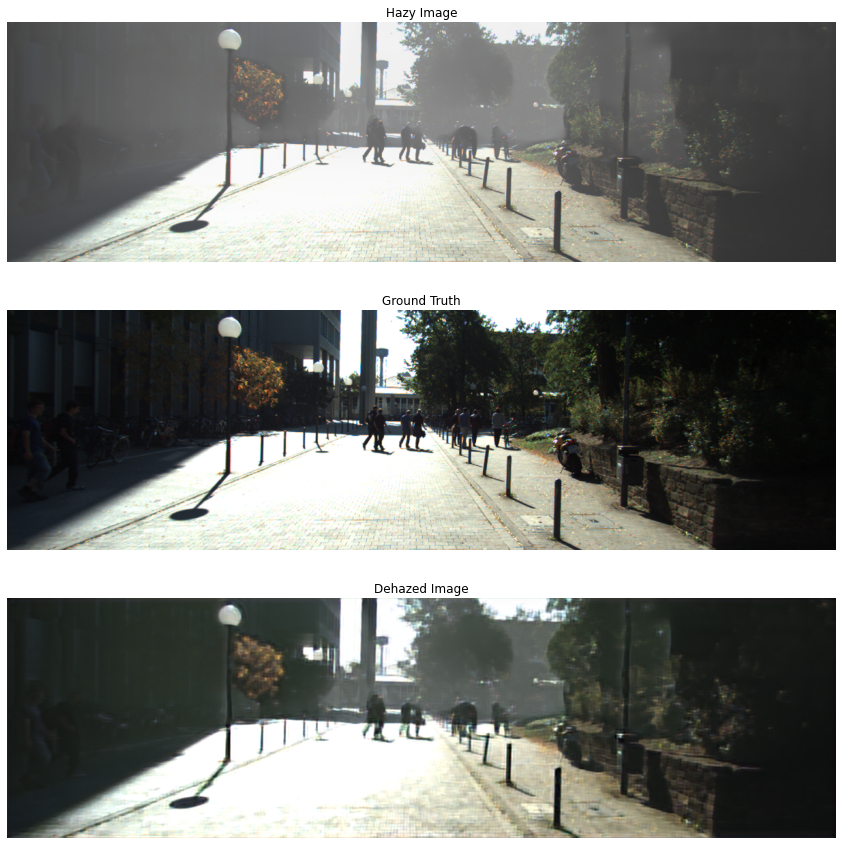

  -  Validation Loss: 0.0090  -   Time taken: 900.24s

Start of epoch 1 [==]  -  Training Loss: 0.0094

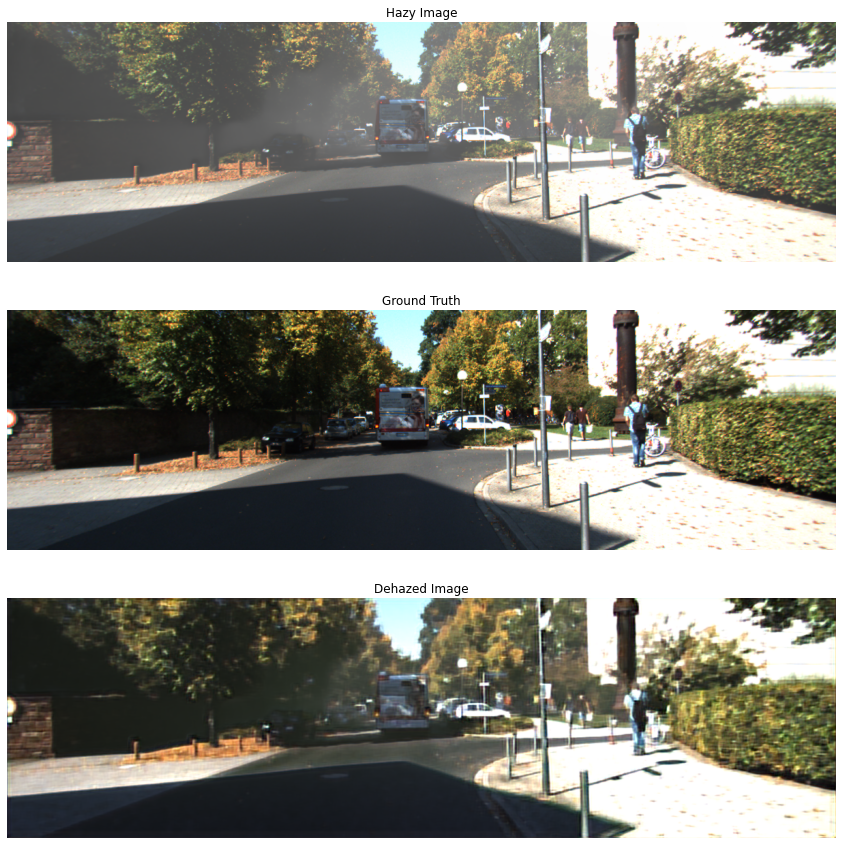

  -  Validation Loss: 0.0086  -   Time taken: 901.07s
CPU times: user 12min 54s, sys: 1min 3s, total: 13min 57s
Wall time: 30min 1s


In [30]:
%%time
train_model(2, train, val,model,train_loss_tracker, val_loss_tracker, tf.keras.optimizers.Adam(learning_rate=1e-4))

In [27]:
model.save('/content/drive/MyDrive/kitti_nets/dehazenet/')
model.save_weights('/content/drive/MyDrive/kitti_nets/dehazenet/')



INFO:tensorflow:Assets written to: /content/drive/MyDrive/kitti_nets/dehazenet/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/kitti_nets/dehazenet/assets



Start of epoch 0 [==]  -  Training Loss: 0.0127

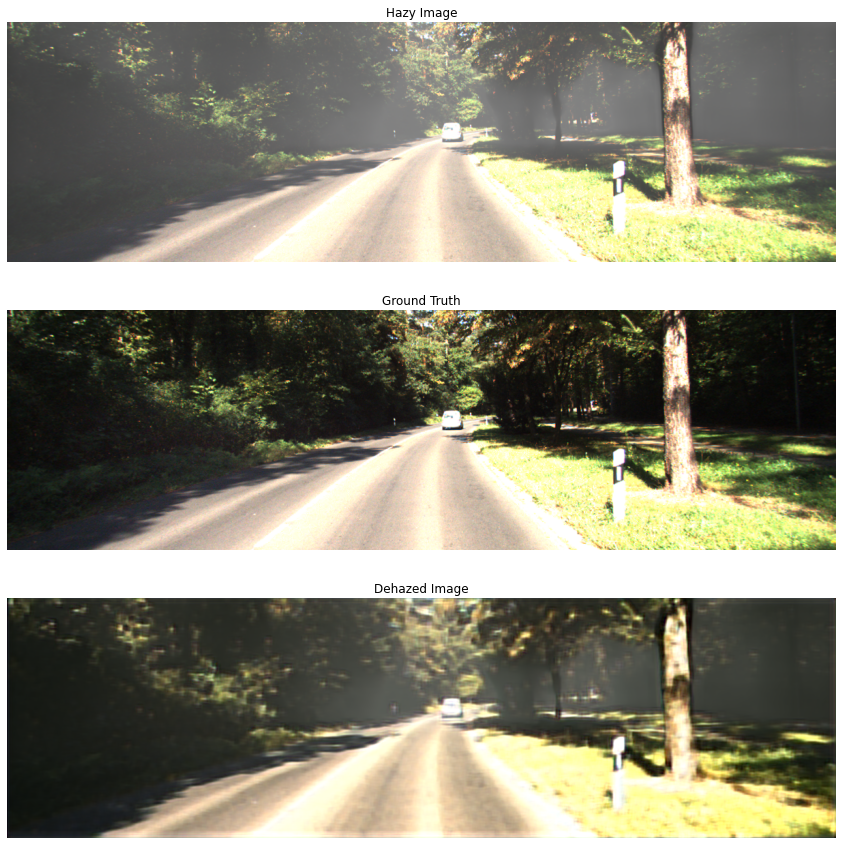

  -  Validation Loss: 0.0121  -   Time taken: 752.62s

Start of epoch 1 [==]  -  Training Loss: 0.0122

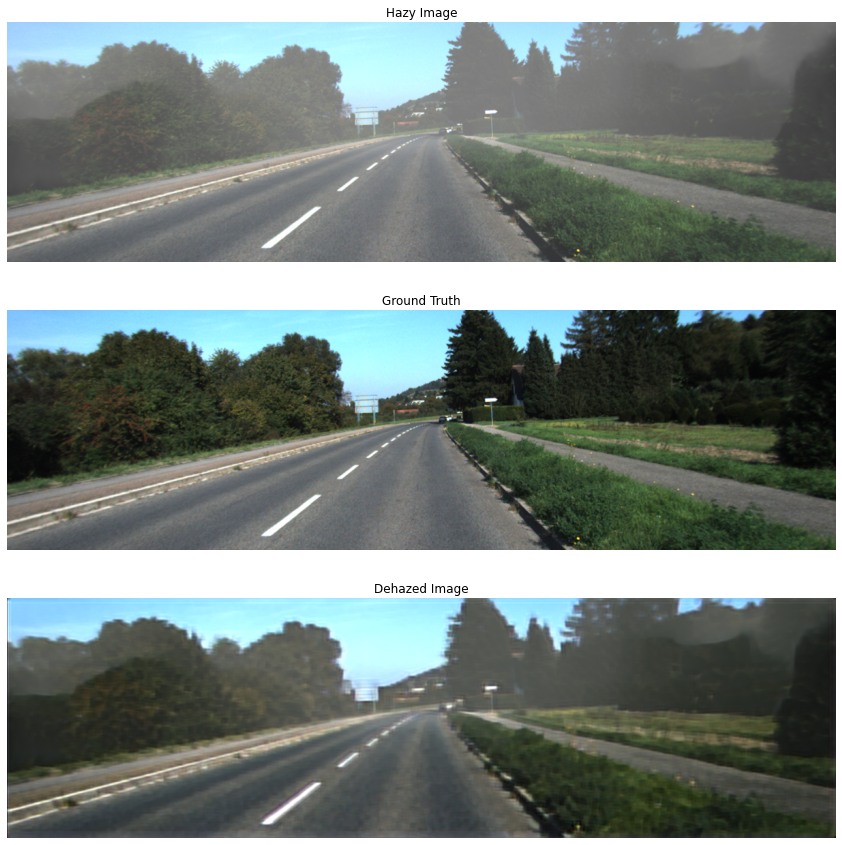

  -  Validation Loss: 0.0120  -   Time taken: 753.25s

Start of epoch 2 [==]  -  Training Loss: 0.0116

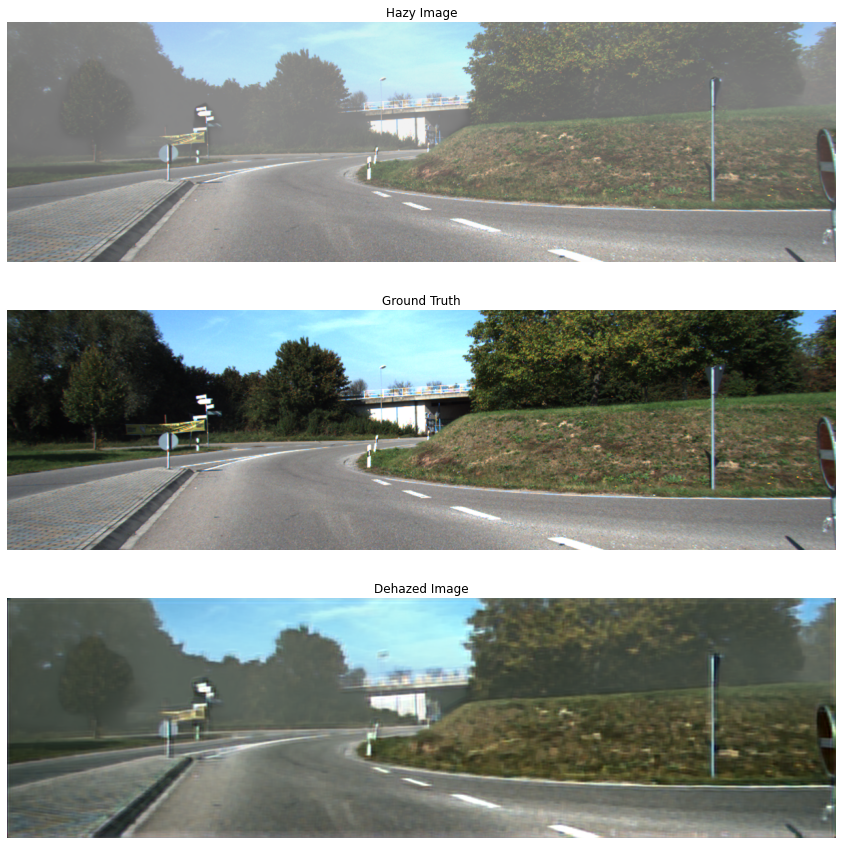

  -  Validation Loss: 0.0114  -   Time taken: 753.61s
CPU times: user 18min 34s, sys: 5min 9s, total: 23min 43s
Wall time: 37min 39s


In [ ]:
%%time
train_model(3, train, val,model,train_loss_tracker, val_loss_tracker, tf.keras.optimizers.Adam(learning_rate=1e-4))

In [32]:
import cv2
import matplotlib.pyplot as plt

def evaluate_gen(net):
    
    #test_img = glob.glob(test_img_path +'/*.jpg')
    test_img=glob.glob('/content/drive/MyDrive/test_set/hazy/*.png')
    #random.shuffle(test_img)
    i=0;
    for img in test_img:
        
        img = tf.io.read_file(img)
        img = tf.io.decode_png(img, channels = 3)
        
        img = tf.image.resize(img, size = (352,1216), antialias = True)
        
        img = img / 255.0
        print(i,end=" ")
        img = tf.expand_dims(img, axis = 0)      #transform input image from 3D to 4D ###
        
        dehaze = net(img)
        
        #plt.figure(figsize = (80, 80))
        
        #display_list = [img[0], dehaze[0]]       #make the first dimension zero
        im=dehaze[0]
        #im=((dehaze[0]-0.4)/0.2)*255
        #print(im.numpy().min())
        directory = '/content/drive/MyDrive/test_set/dehazenet/'
        os.chdir(directory)
        filename = str(i) + '_outdoor_gen.png'
        #print(filename)
        #cv2.imwrite(filename,im) 
        #plt.imsave(filename,im)
        tf.keras.preprocessing.image.save_img(
    filename, im)

        os.chdir('/content')
        i+=1;
        

In [33]:
evaluate_gen(model)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 